# Mini Project 4

**2025 Introduction to Quantitative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model. You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

# <span style="color:blue;"> Sigma is From an Arbitrary Discrete Set of Values </span> #

In [2]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [12]:
%run functions_black_scholes.py

The following code defines a stock path in which sigma takes on a few different values. It uses the following model:
$$
S_{t_n} = S_{t_0}e^{\Sigma_{i=0}^{n-1} \left(\left(\mu - \frac{\sigma_{t_i}^2}{2}\right)\Delta t + \sigma_{t_i}\sqrt{\Delta t}\,\mathcal{N}(0,1)\right)}.
$$

In [13]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simulated stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

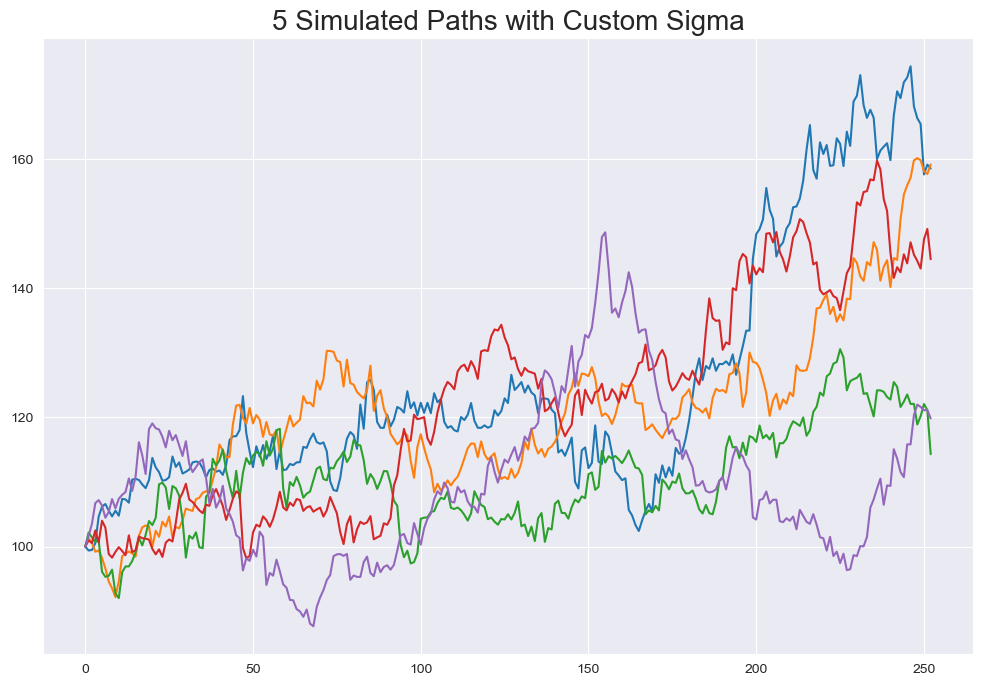

In [14]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

We numerically estimate our hedges as follows. To determine the sigma in our hedge calculations, we consider two methods.
- Option 1: Our most recent sigma is assumed to hold until the option expires.
- Option 2: The mean of our previous sigmas is assumed to estimate our future sigma until the option expires.

We consider our hedges from the point of view of the call option seller.

In [86]:
def bs_MC_call_sell_opt_1(S0, K, sigma_vals, t, r, n_sim, n_hedges, P, num_options, mu):
    # Set times
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step
    
    # Simulate asset paths
    random_noise = np.random.normal(0, 1, size=(n_sim, n_hedges))
    log_returns = (mu+r - 0.5 * sigma_vals**2) * dt + sigma_vals * np.sqrt(dt) * random_noise
    log_paths = np.cumsum(log_returns, axis=1)
    S_paths = S0 * np.exp(log_paths)
    
    # Adjoin S0 to beginning of each stock path
    S_paths = np.hstack([S0 * np.ones((n_sim, 1)), S_paths])  # Shape: (n_sim, n_hedges + 1)
    
    # Compute discounted stock profits from each hedge interval
    # We use the Black-Scholes formula for delta in the simulation
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        sigma = sigma_vals[:, i]
        delta = bs_call_delta(S_start, K, sigma, tte, r)
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)
    
    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)
    
    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)
    
    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)
    
    return pnl

def bs_MC_call_sell_opt_2(S0, K, sigma_vals, t, r, n_sim, n_hedges, P, num_options, mu):
    # Set times
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step
    
    # Simulate asset paths
    random_noise = np.random.normal(0, 1, size=(n_sim, n_hedges))
    log_returns = (mu+r - 0.5 * sigma_vals**2) * dt + sigma_vals * np.sqrt(dt) * random_noise
    log_paths = np.cumsum(log_returns, axis=1)
    S_paths = S0 * np.exp(log_paths)
    
    # Adjoin S0 to beginning of each stock path
    S_paths = np.hstack([S0 * np.ones((n_sim, 1)), S_paths])  # Shape: (n_sim, n_hedges + 1)
    
    # Compute discounted stock profits from each hedge interval
    # We use the Black-Scholes formula for delta in the simulation
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        sigma = np.mean(sigma_vals[:, 0:(i+1)], axis=1)
        delta = bs_call_delta(S_start, K, sigma, tte, r)
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)
    
    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)
    
    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)
    
    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)
    
    return pnl

In [105]:
S0 = 100
K = 104
t = 1
r = 0.039
mu = 0.275

n_sim = 100000
num_options = 100
P = 10

n_delta_hedges = [2, 10, 20, 50, 252]

sigma_vec = [.2, .3, .45]
sigma_prob = [.5, .3, .2]

sigma_min = min(sigma_vec)
sigma_mean = np.dot(sigma_vec, sigma_prob)
sigma_max = max(sigma_vec)
bs_min_call = bs_call(S0, K, sigma_min, t, r)
bs_mean_call = bs_call(S0, K, sigma_mean, t, r)
bs_max_call = bs_call(S0, K, sigma_max, t, r)

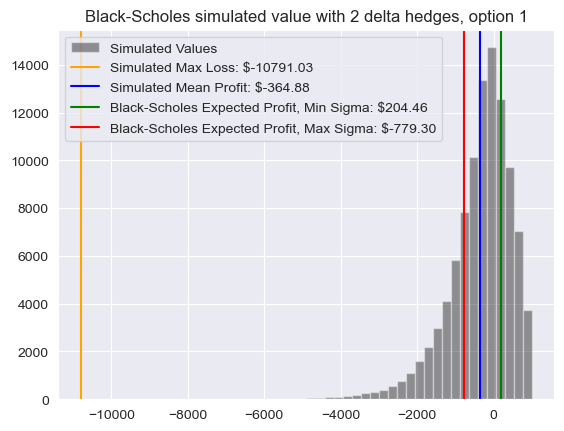

Black-Scholes simulated value with 2 delta hedges: $-364.88
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $855.66
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


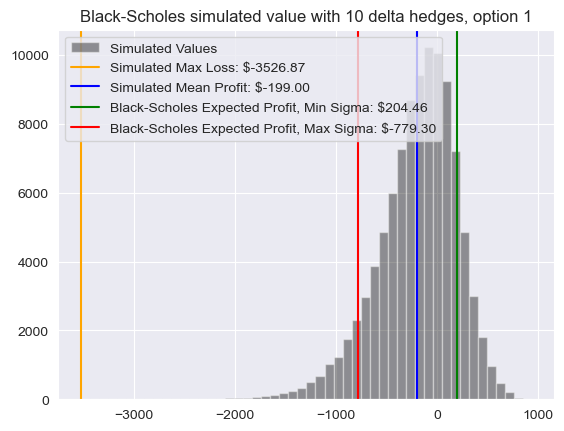

Black-Scholes simulated value with 10 delta hedges: $-199.00
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $396.85
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


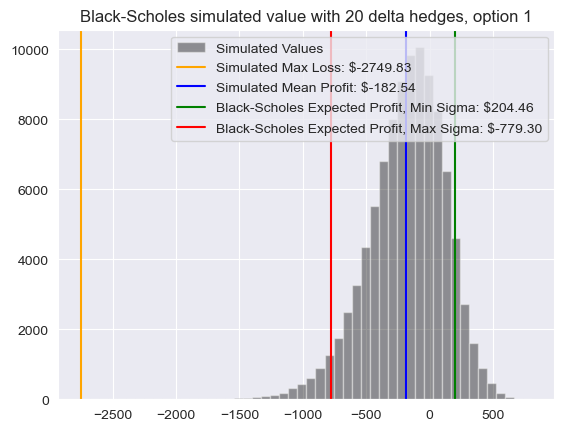

Black-Scholes simulated value with 20 delta hedges: $-182.54
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $302.95
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


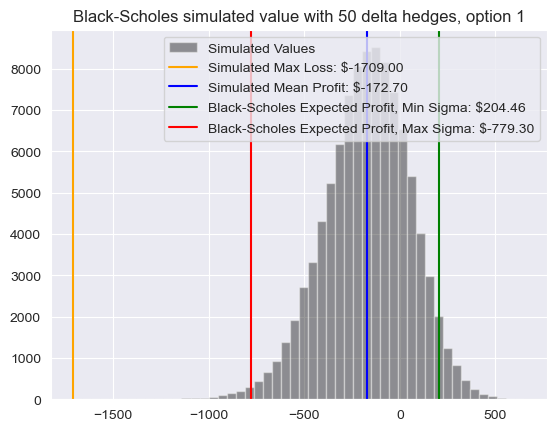

Black-Scholes simulated value with 50 delta hedges: $-172.70
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $226.69
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


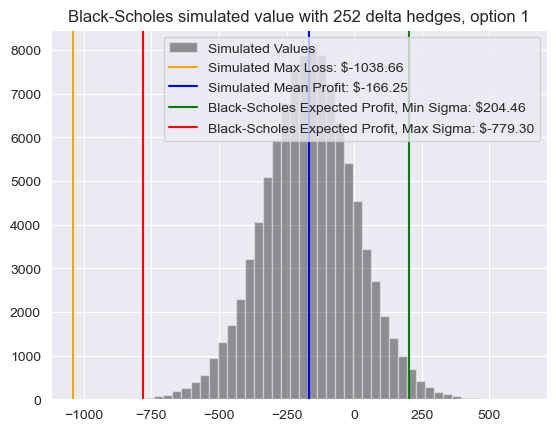

Black-Scholes simulated value with 252 delta hedges: $-166.25
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $170.94
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Assuming the Black-Scholes equation with constant volatility,
the profit/loss would be as follows:
        Volatility            Profit/Loss
------------------------------------------------
Minimum volatility 0.200      $204.46
Mean volatility    0.280      $-112.42
Maximum volatility 0.450      $-779.30
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [108]:
# Implement option 1
for n_hedges in n_delta_hedges:
    # Custom sigma that is not constant
    sigma_vals = np.random.choice(sigma_vec, p = sigma_prob, size = (n_sim, n_hedges))
    
    X = bs_MC_call_sell_opt_1(S0, K, sigma_vals, t, r, n_sim, n_hedges, P, num_options, mu)
    
    plt.hist(X, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

    plt.axvline(np.min(X), label = f'Simulated Max Loss: ${np.min(X):.2f}', color = 'orange')
    plt.axvline(np.mean(X), label = f'Simulated Mean Profit: ${np.mean(X):.2f}', color = 'blue')

    plt.axvline(num_options*(P-bs_min_call), label = f'Black-Scholes Expected Profit, Min Sigma: ${num_options*(P-bs_min_call):.2f}', color = 'green')
    plt.axvline(num_options*(P-bs_max_call), label = f'Black-Scholes Expected Profit, Max Sigma: ${num_options*(P-bs_max_call):.2f}', color = 'red')
    
    plt.legend()
    plt.title(f'Black-Scholes simulated value with {n_hedges} delta hedges, option 1')
    plt.show()
        
    print(f'Black-Scholes simulated value with {n_hedges} delta hedges: ${np.mean(X):.2f}')
    print('----'*20)
    print('----'*20)
    print(f'Standard Deviation of Simulated Values: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)

print(f'Assuming the Black-Scholes equation with constant volatility,\nthe profit/loss would be as follows:')
print(f'        Volatility            Profit/Loss')
print('----'*12)
print(f'Minimum volatility {sigma_min:.3f}      ${num_options*(P-bs_min_call):.2f}')
print(f'Mean volatility    {sigma_mean:.3f}      ${num_options*(P-bs_mean_call):.2f}')
print(f'Maximum volatility {sigma_max:.3f}      ${num_options*(P-bs_max_call):.2f}')
print('----'*20)
print('----'*20)

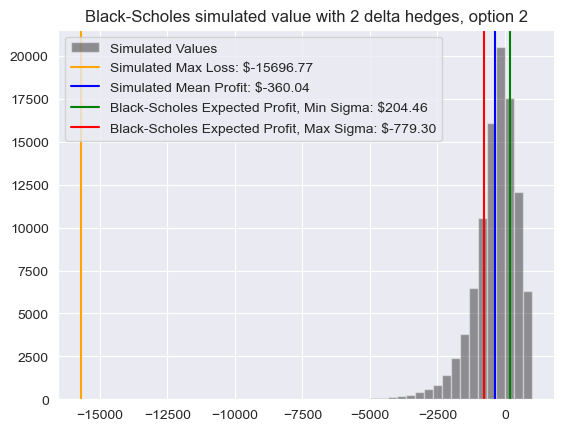

Black-Scholes simulated value with 2 delta hedges: $-360.04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $849.85
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


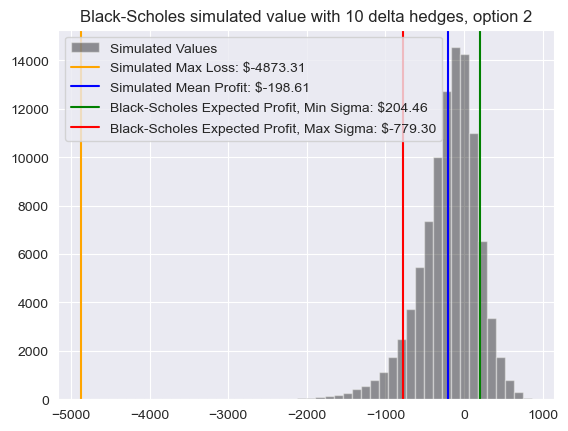

Black-Scholes simulated value with 10 delta hedges: $-198.61
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $383.97
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


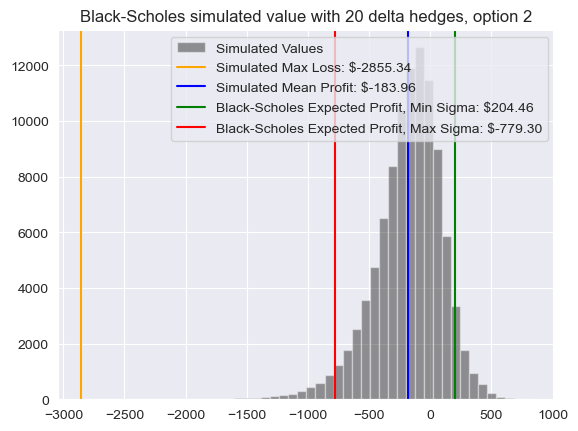

Black-Scholes simulated value with 20 delta hedges: $-183.96
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $279.24
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


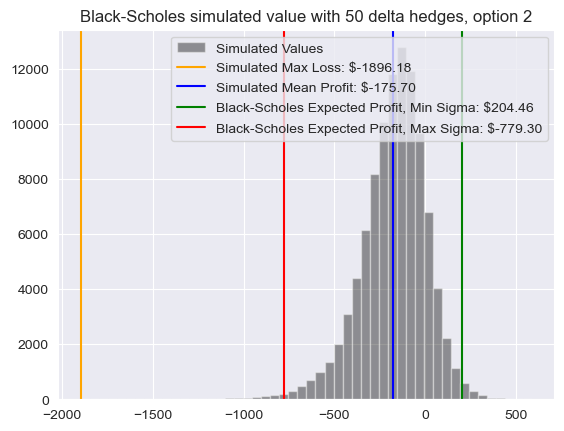

Black-Scholes simulated value with 50 delta hedges: $-175.70
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $181.60
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


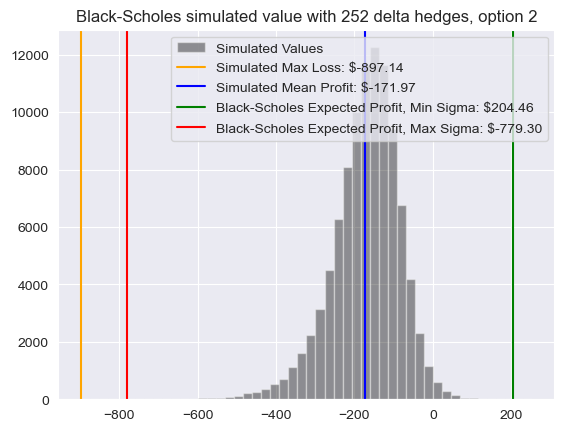

Black-Scholes simulated value with 252 delta hedges: $-171.97
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $86.21
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Assuming the Black-Scholes equation with constant volatility,
the profit/loss would be as follows:
        Volatility            Profit/Loss
------------------------------------------------
Minimum volatility 0.200      $204.46
Mean volatility    0.280      $-112.42
Maximum volatility 0.450      $-779.30
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [109]:
# Implement option 2
for n_hedges in n_delta_hedges:
    # Custom sigma that is not constant
    sigma_vals = np.random.choice(sigma_vec, p = sigma_prob, size = (n_sim, n_hedges))
    
    X = bs_MC_call_sell_opt_2(S0, K, sigma_vals, t, r, n_sim, n_hedges, P, num_options, mu)
    
    plt.hist(X, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

    plt.axvline(np.min(X), label = f'Simulated Max Loss: ${np.min(X):.2f}', color = 'orange')
    plt.axvline(np.mean(X), label = f'Simulated Mean Profit: ${np.mean(X):.2f}', color = 'blue')

    plt.axvline(num_options*(P-bs_min_call), label = f'Black-Scholes Expected Profit, Min Sigma: ${num_options*(P-bs_min_call):.2f}', color = 'green')
    plt.axvline(num_options*(P-bs_max_call), label = f'Black-Scholes Expected Profit, Max Sigma: ${num_options*(P-bs_max_call):.2f}', color = 'red')
    
    plt.legend()
    plt.title(f'Black-Scholes simulated value with {n_hedges} delta hedges, option 2')
    plt.show()
        
    print(f'Black-Scholes simulated value with {n_hedges} delta hedges: ${np.mean(X):.2f}')
    print('----'*20)
    print('----'*20)
    print(f'Standard Deviation of Simulated Values: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)

print(f'Assuming the Black-Scholes equation with constant volatility,\nthe profit/loss would be as follows:')
print(f'        Volatility            Profit/Loss')
print('----'*12)
print(f'Minimum volatility {sigma_min:.3f}      ${num_options*(P-bs_min_call):.2f}')
print(f'Mean volatility    {sigma_mean:.3f}      ${num_options*(P-bs_mean_call):.2f}')
print(f'Maximum volatility {sigma_max:.3f}      ${num_options*(P-bs_max_call):.2f}')
print('----'*20)
print('----'*20)

We note that with our above method, we can only numerically estimate the profit/loss. We cannot determine it precisely using the Black-Scholes equations since the volatility is variable. For comparison, we consider a Monte-Carlo simulation of the profit/loss assuming the volatility is constant.

In [110]:
S0 = 100
K = 104
t = 1
r = 0.039
mu = 0.275

n_sim = 100000
num_options = 100
P = 10

n_delta_hedges = [2, 10, 20, 50]

sigma_vec = [.2, .3, .45]
sigma_prob = [.5, .3, .2]

sigma_min = min(sigma_vec)
sigma_mean = np.dot(sigma_vec, sigma_prob)
sigma_max = max(sigma_vec)
bs_min_call = bs_call(S0, K, sigma_min, t, r)
bs_mean_call = bs_call(S0, K, sigma_mean, t, r)
bs_max_call = bs_call(S0, K, sigma_max, t, r)

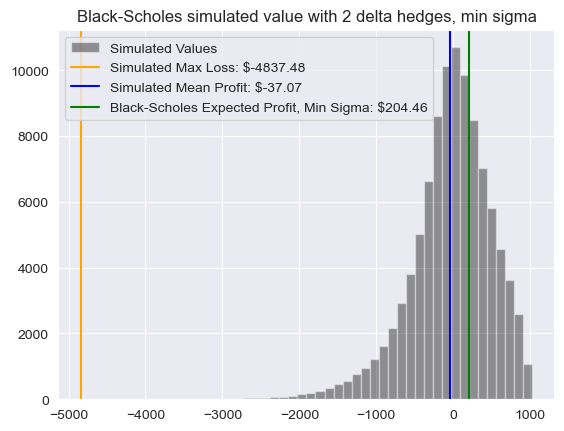

Black-Scholes simulated value with 2 delta hedges: $-37.07
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $533.09
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


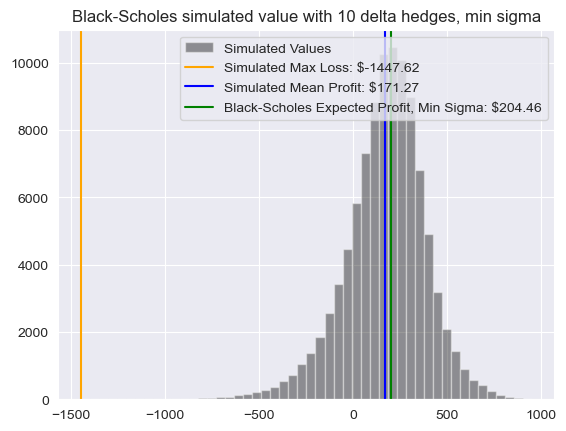

Black-Scholes simulated value with 10 delta hedges: $171.27
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $213.71
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


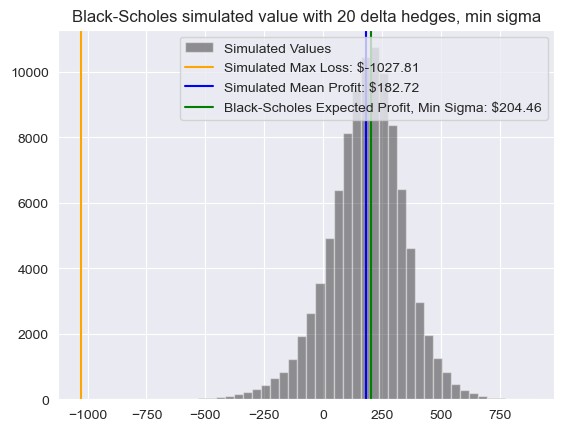

Black-Scholes simulated value with 20 delta hedges: $182.72
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $160.64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


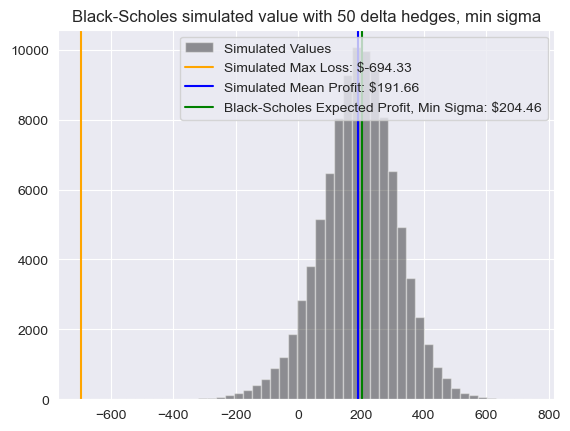

Black-Scholes simulated value with 50 delta hedges: $191.66
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $122.15
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Assuming the Black-Scholes equation with constant volatility,
the profit/loss would be as follows:
        Volatility            Profit/Loss
------------------------------------------------
Minimum volatility 0.200      $204.46
Mean volatility    0.280      $-112.42
Maximum volatility 0.450      $-779.30
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [111]:
# Use sigma_min
delta_sims = 100

for n_hedges in n_delta_hedges:
    profits_hedged = bs_MC_call(S0, K, sigma_min, t, r, mu, n_sim, n_hedges, delta_sims)

    X = num_options*(P-profits_hedged)
    
    plt.hist(X, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

    plt.axvline(np.min(X), label = f'Simulated Max Loss: ${np.min(X):.2f}', color = 'orange')
    plt.axvline(np.mean(X), label = f'Simulated Mean Profit: ${np.mean(X):.2f}', color = 'blue')

    plt.axvline(num_options*(P-bs_min_call), label = f'Black-Scholes Expected Profit, Min Sigma: ${num_options*(P-bs_min_call):.2f}', color = 'green')
    
    plt.legend()
    plt.title(f'Black-Scholes simulated value with {n_hedges} delta hedges, min sigma')
    plt.show()
        
    print(f'Black-Scholes simulated value with {n_hedges} delta hedges: ${np.mean(X):.2f}')
    print('----'*20)
    print('----'*20)
    print(f'Standard Deviation of Simulated Values: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)

print(f'Assuming the Black-Scholes equation with constant volatility,\nthe profit/loss would be as follows:')
print(f'        Volatility            Profit/Loss')
print('----'*12)
print(f'Minimum volatility {sigma_min:.3f}      ${num_options*(P-bs_min_call):.2f}')
print(f'Mean volatility    {sigma_mean:.3f}      ${num_options*(P-bs_mean_call):.2f}')
print(f'Maximum volatility {sigma_max:.3f}      ${num_options*(P-bs_max_call):.2f}')
print('----'*20)
print('----'*20)

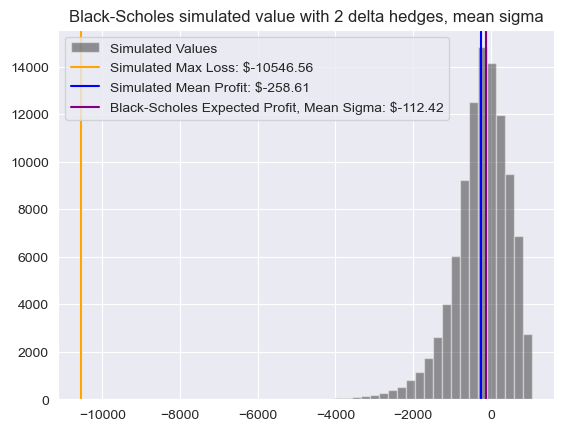

Black-Scholes simulated value with 2 delta hedges: $-258.61
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $724.79
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


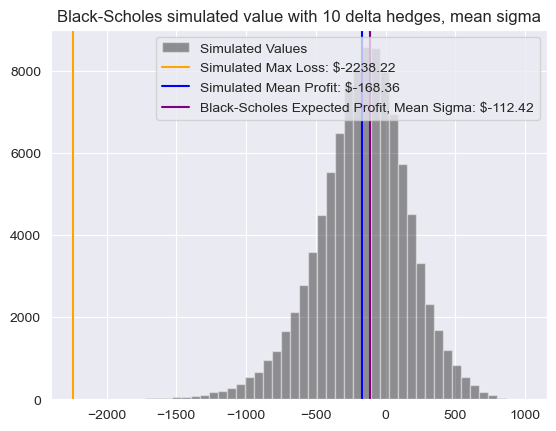

Black-Scholes simulated value with 10 delta hedges: $-168.36
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $331.79
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


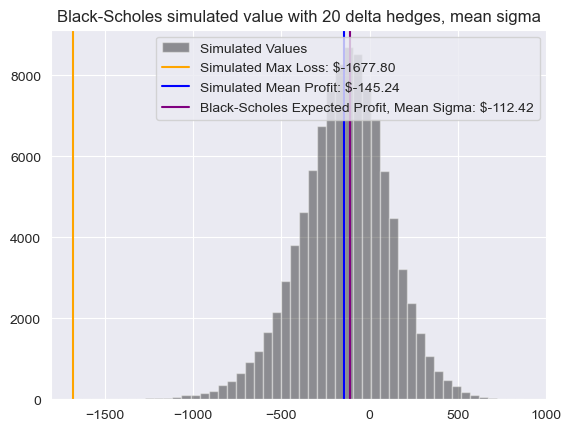

Black-Scholes simulated value with 20 delta hedges: $-145.24
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $256.49
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


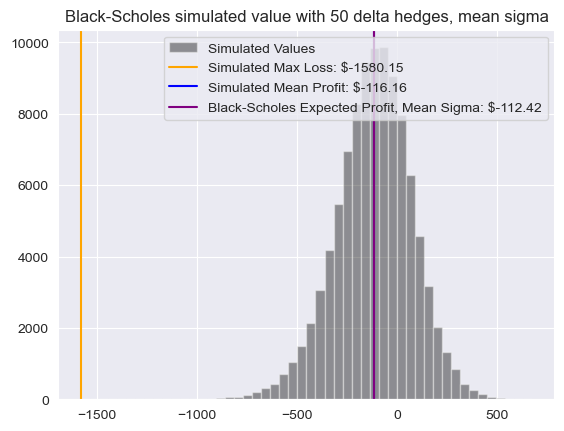

Black-Scholes simulated value with 50 delta hedges: $-116.16
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $190.99
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Assuming the Black-Scholes equation with constant volatility,
the profit/loss would be as follows:
        Volatility            Profit/Loss
------------------------------------------------
Minimum volatility 0.200      $204.46
Mean volatility    0.280      $-112.42
Maximum volatility 0.450      $-779.30
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [112]:
# Use sigma_mean
delta_sims = 100

for n_hedges in n_delta_hedges:
    profits_hedged = bs_MC_call(S0, K, sigma_mean, t, r, mu, n_sim, n_hedges, delta_sims)

    X = num_options*(P-profits_hedged)
    
    plt.hist(X, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

    plt.axvline(np.min(X), label = f'Simulated Max Loss: ${np.min(X):.2f}', color = 'orange')
    plt.axvline(np.mean(X), label = f'Simulated Mean Profit: ${np.mean(X):.2f}', color = 'blue')

    plt.axvline(num_options*(P-bs_mean_call), label = f'Black-Scholes Expected Profit, Mean Sigma: ${num_options*(P-bs_mean_call):.2f}', color = 'purple')
    
    plt.legend()
    plt.title(f'Black-Scholes simulated value with {n_hedges} delta hedges, mean sigma')
    plt.show()
        
    print(f'Black-Scholes simulated value with {n_hedges} delta hedges: ${np.mean(X):.2f}')
    print('----'*20)
    print('----'*20)
    print(f'Standard Deviation of Simulated Values: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)

print(f'Assuming the Black-Scholes equation with constant volatility,\nthe profit/loss would be as follows:')
print(f'        Volatility            Profit/Loss')
print('----'*12)
print(f'Minimum volatility {sigma_min:.3f}      ${num_options*(P-bs_min_call):.2f}')
print(f'Mean volatility    {sigma_mean:.3f}      ${num_options*(P-bs_mean_call):.2f}')
print(f'Maximum volatility {sigma_max:.3f}      ${num_options*(P-bs_max_call):.2f}')
print('----'*20)
print('----'*20)

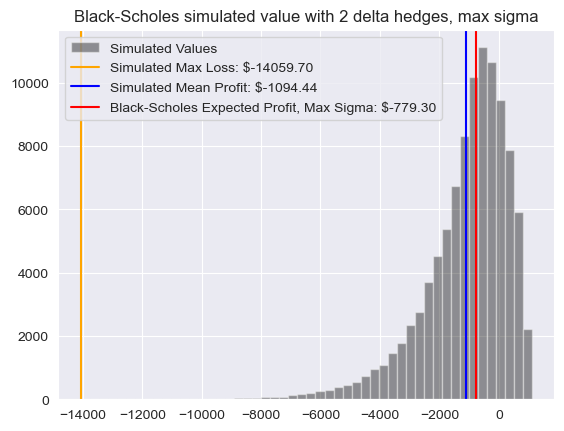

Black-Scholes simulated value with 2 delta hedges: $-1094.44
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $1462.10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


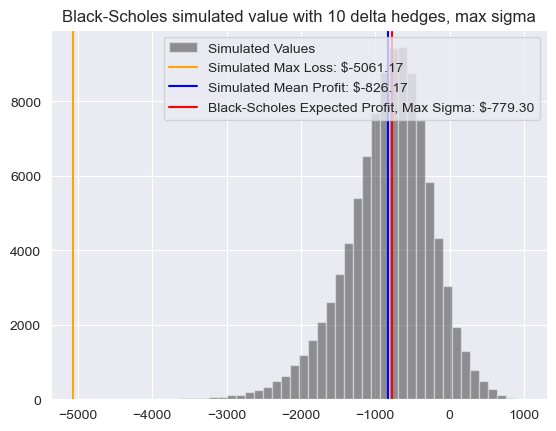

Black-Scholes simulated value with 10 delta hedges: $-826.17
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $579.78
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


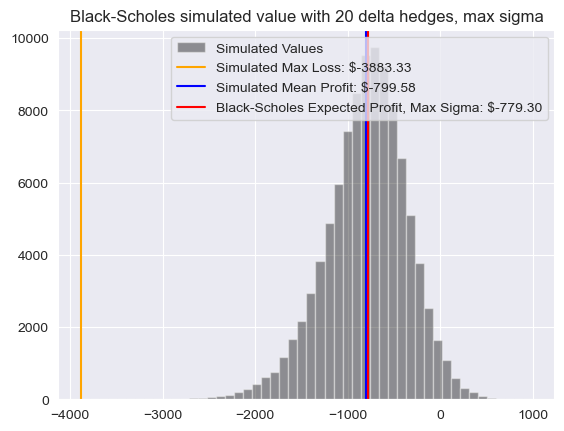

Black-Scholes simulated value with 20 delta hedges: $-799.58
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $443.28
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


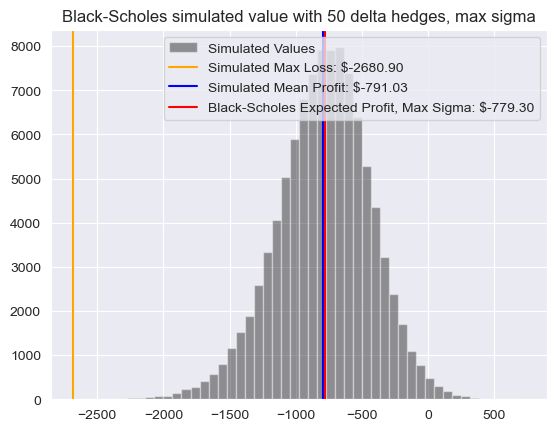

Black-Scholes simulated value with 50 delta hedges: $-791.03
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $355.41
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Assuming the Black-Scholes equation with constant volatility,
the profit/loss would be as follows:
        Volatility            Profit/Loss
------------------------------------------------
Minimum volatility 0.200      $204.46
Mean volatility    0.280      $-112.42
Maximum volatility 0.450      $-779.30
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [113]:
# Use sigma_max
delta_sims = 100

for n_hedges in n_delta_hedges:
    profits_hedged = bs_MC_call(S0, K, sigma_max, t, r, mu, n_sim, n_hedges, delta_sims)

    X = num_options*(P-profits_hedged)
    
    plt.hist(X, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

    plt.axvline(np.min(X), label = f'Simulated Max Loss: ${np.min(X):.2f}', color = 'orange')
    plt.axvline(np.mean(X), label = f'Simulated Mean Profit: ${np.mean(X):.2f}', color = 'blue')

    plt.axvline(num_options*(P-bs_max_call), label = f'Black-Scholes Expected Profit, Max Sigma: ${num_options*(P-bs_max_call):.2f}', color = 'red')
    
    plt.legend()
    plt.title(f'Black-Scholes simulated value with {n_hedges} delta hedges, max sigma')
    plt.show()
        
    print(f'Black-Scholes simulated value with {n_hedges} delta hedges: ${np.mean(X):.2f}')
    print('----'*20)
    print('----'*20)
    print(f'Standard Deviation of Simulated Values: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)

print(f'Assuming the Black-Scholes equation with constant volatility,\nthe profit/loss would be as follows:')
print(f'        Volatility            Profit/Loss')
print('----'*12)
print(f'Minimum volatility {sigma_min:.3f}      ${num_options*(P-bs_min_call):.2f}')
print(f'Mean volatility    {sigma_mean:.3f}      ${num_options*(P-bs_mean_call):.2f}')
print(f'Maximum volatility {sigma_max:.3f}      ${num_options*(P-bs_max_call):.2f}')
print('----'*20)
print('----'*20)

We now have distributions of profit/loss using the following approximations:
1. variable volatility: the most recent volatility is assumed to hold until the option expires,
2. variable volatility: the mean of our previous sigmas is assumed to estimate our future sigma until the option expires,
3. constant volatility: sigma is the minimum volatility,
4. constant volatility: sigma is the mean volatility, and
5. constant volatility: sigma is the maximum volatility.

*Expected Values*

Overall, the model using the mimimum volatility produced the greatest expected profit. The model using the maximum volatility produced the greatest expected loss. This aligns with what we would expect since sellers of call options have a risk of theoretically infinite loss. If the volatility is large, we expect the loss to be large as well. If the volatility is small, we expect the loss to be small, and there may even be a profit.

For the variable volatility cases, the expected losses for the two options were approximately the same. The expected losses for the variable volatility cases were between the expected losses of using the mean and max volatilities.

*Standard Deviations* 

The model using the minimum volatility had the smallest standard deviation for its simulated values, and the model using the maximum volatility had the largest standard deviation. This aligns with what we would expect since the variability of a distribution of samples is proportional to the variability of the distribution the sample is drawn from.

For the variable volatility cases, the standard deviation of option 2 was less than the standard deviation of option 1. We investigate the reason for this by considering another volatility distribution. Below, we consider options 1 and 2 with a volatility distribution that is skewed with higher probabilities towards higher values.

In [126]:
S0 = 100
K = 104
t = 1
r = 0.039
mu = 0.275

n_sim = 100000
num_options = 100
P = 10

n_delta_hedges = [2, 10, 20, 50, 252]

sigma_vec = [.1, .4, .6, .7, .75]
sigma_prob = [.05, .1, .15, .2, .5]

sigma_min = min(sigma_vec)
sigma_mean = np.dot(sigma_vec, sigma_prob)
sigma_max = max(sigma_vec)
bs_min_call = bs_call(S0, K, sigma_min, t, r)
bs_mean_call = bs_call(S0, K, sigma_mean, t, r)
bs_max_call = bs_call(S0, K, sigma_max, t, r)

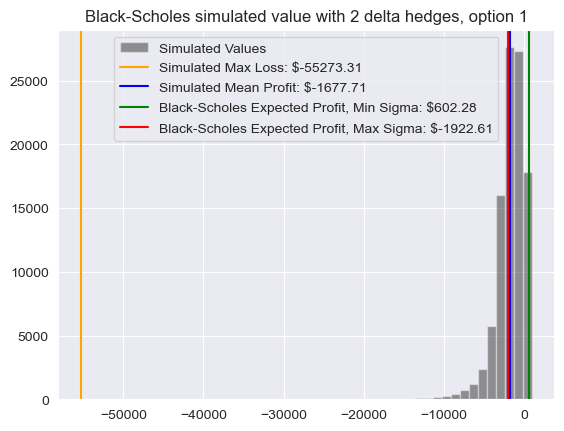

Black-Scholes simulated value with 2 delta hedges: $-1677.71
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $1830.49
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


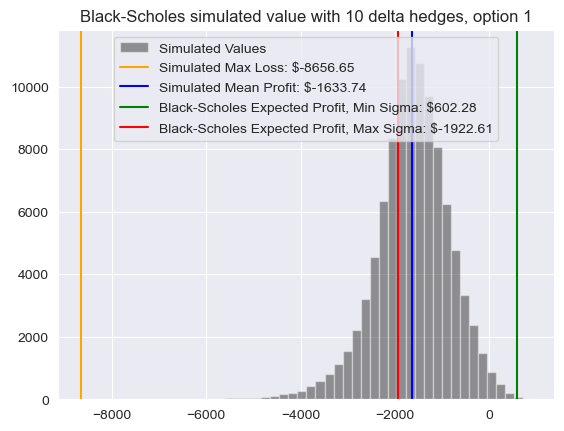

Black-Scholes simulated value with 10 delta hedges: $-1633.74
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $790.61
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


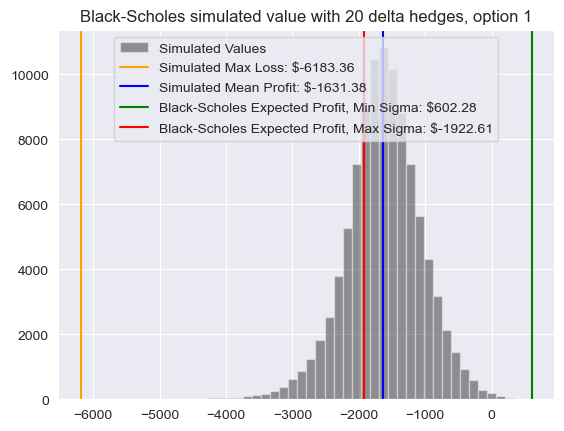

Black-Scholes simulated value with 20 delta hedges: $-1631.38
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $568.13
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


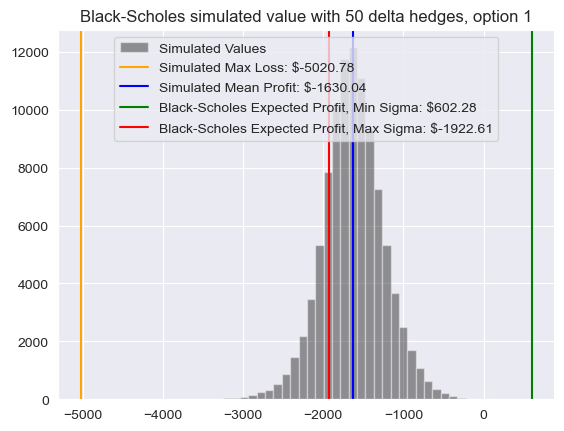

Black-Scholes simulated value with 50 delta hedges: $-1630.04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $382.92
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


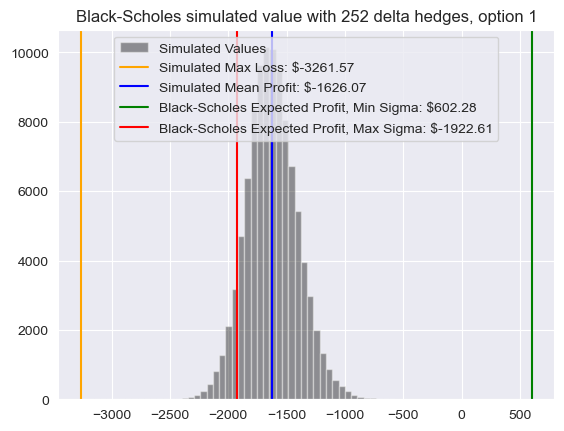

Black-Scholes simulated value with 252 delta hedges: $-1626.07
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $220.24
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Assuming the Black-Scholes equation with constant volatility,
the profit/loss would be as follows:
        Volatility            Profit/Loss
------------------------------------------------
Minimum volatility 0.100      $602.28
Mean volatility    0.650      $-1547.37
Maximum volatility 0.750      $-1922.61
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [127]:
# Implement option 1
for n_hedges in n_delta_hedges:
    # Custom sigma that is not constant
    sigma_vals = np.random.choice(sigma_vec, p = sigma_prob, size = (n_sim, n_hedges))
    
    X = bs_MC_call_sell_opt_1(S0, K, sigma_vals, t, r, n_sim, n_hedges, P, num_options, mu)
    
    plt.hist(X, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

    plt.axvline(np.min(X), label = f'Simulated Max Loss: ${np.min(X):.2f}', color = 'orange')
    plt.axvline(np.mean(X), label = f'Simulated Mean Profit: ${np.mean(X):.2f}', color = 'blue')

    plt.axvline(num_options*(P-bs_min_call), label = f'Black-Scholes Expected Profit, Min Sigma: ${num_options*(P-bs_min_call):.2f}', color = 'green')
    plt.axvline(num_options*(P-bs_max_call), label = f'Black-Scholes Expected Profit, Max Sigma: ${num_options*(P-bs_max_call):.2f}', color = 'red')
    
    plt.legend()
    plt.title(f'Black-Scholes simulated value with {n_hedges} delta hedges, option 1')
    plt.show()
        
    print(f'Black-Scholes simulated value with {n_hedges} delta hedges: ${np.mean(X):.2f}')
    print('----'*20)
    print('----'*20)
    print(f'Standard Deviation of Simulated Values: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)

print(f'Assuming the Black-Scholes equation with constant volatility,\nthe profit/loss would be as follows:')
print(f'        Volatility            Profit/Loss')
print('----'*12)
print(f'Minimum volatility {sigma_min:.3f}      ${num_options*(P-bs_min_call):.2f}')
print(f'Mean volatility    {sigma_mean:.3f}      ${num_options*(P-bs_mean_call):.2f}')
print(f'Maximum volatility {sigma_max:.3f}      ${num_options*(P-bs_max_call):.2f}')
print('----'*20)
print('----'*20)

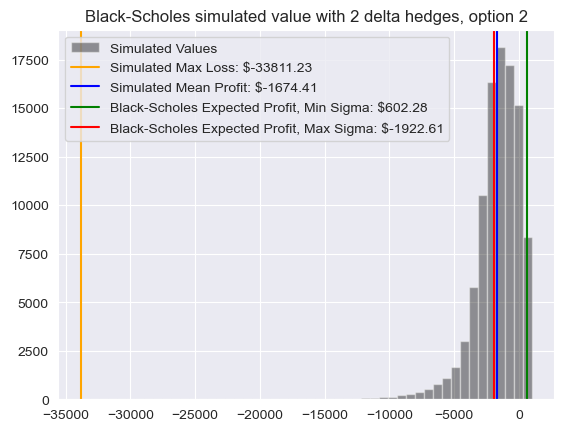

Black-Scholes simulated value with 2 delta hedges: $-1674.41
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $1813.06
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


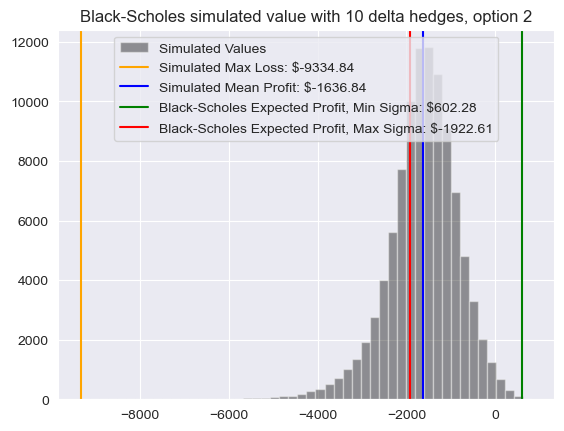

Black-Scholes simulated value with 10 delta hedges: $-1636.84
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $792.83
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


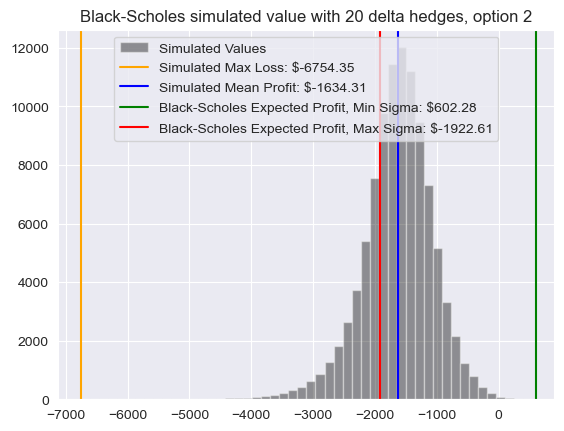

Black-Scholes simulated value with 20 delta hedges: $-1634.31
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $563.50
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


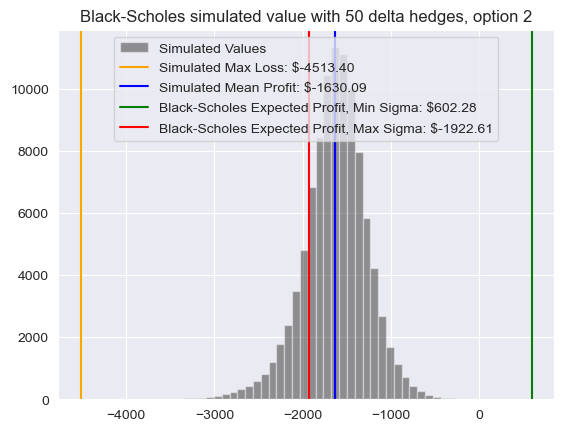

Black-Scholes simulated value with 50 delta hedges: $-1630.09
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $362.29
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


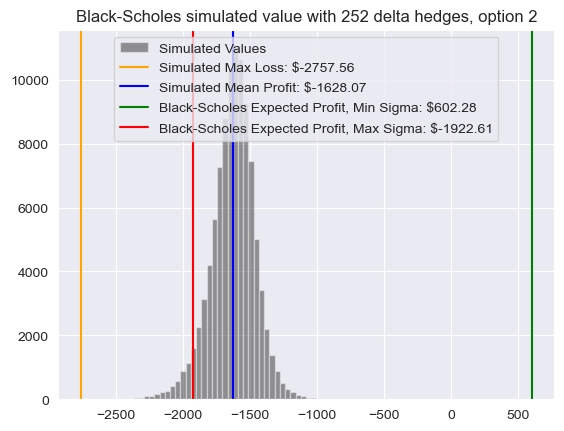

Black-Scholes simulated value with 252 delta hedges: $-1628.07
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Standard Deviation of Simulated Values: $165.42
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Assuming the Black-Scholes equation with constant volatility,
the profit/loss would be as follows:
        Volatility            Profit/Loss
------------------------------------------------
Minimum volatility 0.100      $602.28
Mean volatility    0.650      $-1547.37
Maximum volatility 0.750      $-1922.61
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [128]:
# Implement option 2
for n_hedges in n_delta_hedges:
    # Custom sigma that is not constant
    sigma_vals = np.random.choice(sigma_vec, p = sigma_prob, size = (n_sim, n_hedges))
    
    X = bs_MC_call_sell_opt_2(S0, K, sigma_vals, t, r, n_sim, n_hedges, P, num_options, mu)
    
    plt.hist(X, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

    plt.axvline(np.min(X), label = f'Simulated Max Loss: ${np.min(X):.2f}', color = 'orange')
    plt.axvline(np.mean(X), label = f'Simulated Mean Profit: ${np.mean(X):.2f}', color = 'blue')

    plt.axvline(num_options*(P-bs_min_call), label = f'Black-Scholes Expected Profit, Min Sigma: ${num_options*(P-bs_min_call):.2f}', color = 'green')
    plt.axvline(num_options*(P-bs_max_call), label = f'Black-Scholes Expected Profit, Max Sigma: ${num_options*(P-bs_max_call):.2f}', color = 'red')
    
    plt.legend()
    plt.title(f'Black-Scholes simulated value with {n_hedges} delta hedges, option 2')
    plt.show()
        
    print(f'Black-Scholes simulated value with {n_hedges} delta hedges: ${np.mean(X):.2f}')
    print('----'*20)
    print('----'*20)
    print(f'Standard Deviation of Simulated Values: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)

print(f'Assuming the Black-Scholes equation with constant volatility,\nthe profit/loss would be as follows:')
print(f'        Volatility            Profit/Loss')
print('----'*12)
print(f'Minimum volatility {sigma_min:.3f}      ${num_options*(P-bs_min_call):.2f}')
print(f'Mean volatility    {sigma_mean:.3f}      ${num_options*(P-bs_mean_call):.2f}')
print(f'Maximum volatility {sigma_max:.3f}      ${num_options*(P-bs_max_call):.2f}')
print('----'*20)
print('----'*20)

*Standard Deviation*

As before, the standard deviation of simulated values for option 2 is smaller than for option 1. We expect this is due to option 2 repeatedly averaging the volatility values used in the model. The shape of the distribution from which the volatility values are drawn does not seem to have an influence on which option produces a smaller standard deviation of the simulated values.